# Feature Visualization

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE). 

## Imports

In [1]:
import sys
sys.path.append('lib/')
from esu_util import *

import numpy as np

import torch as t
import torch.nn as nn
import torchvision as tv

from inception_debug import inception_v3

## Model

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# Load model
# model = tv.models.vgg19(pretrained=True).to(device)
model = inception_v3(pretrained=True).to(device)

ORIGINAL_SIZE = 299 # Inception V3
# ORIGINAL_SIZE = 224 # VGG

# Test mode
model.eval()

print('Available modules:')
for n, name_module in enumerate(model.named_children()):
    print(n, name_module[0])
f = model # Alias

Available modules:
0 Conv2d_1a_3x3
1 Conv2d_2a_3x3
2 Conv2d_2b_3x3
3 Conv2d_3b_1x1
4 Conv2d_4a_3x3
5 Mixed_5b
6 Mixed_5c
7 Mixed_5d
8 Mixed_6a
9 Mixed_6b
10 Mixed_6c
11 Mixed_6d
12 Mixed_6e
13 AuxLogits
14 Mixed_7a
15 Mixed_7b
16 Mixed_7c
17 fc


## Gradient Ascent function

In [3]:
def gradient_ascent(img, layer, neuron, shape):
    
    # Parameters
    ITERATIONS = 200 # Per octave
    FILTERS = [{'function':filter_median, 'frequency':4, 'params':{'fsize':5}}] # Good for all
    # FILTERS = [{'function':filter_TV, 'frequency':20, 'params':{}}] # Good for Inception V3
    # FILTERS = [{'function':filter_TV, 'frequency':20, 'params':{}}] # Good for VGG
    JITTER = 32 # Good for all
    LR = 0.4 # Good for all
    L2 = 1e-4 # Good for all (Yosinski L2)
    
    # Pytorch is channels first, this happens here!
    preprocess = tv.transforms.Compose([tv.transforms.Resize(shape), tv.transforms.ToTensor()])
    
    # unsqueeze(0) adds batch dimension
    # requires_grad_() switches on gradients (gradients for the model are switched off in model.eval())
    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)
    
    for i in range(ITERATIONS):
        
        optimizer.zero_grad()
        
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            ox, oy = np.random.randint(-JITTER, JITTER+1, 2)
            npimg = np.roll(np.roll(npimg, ox, -1), oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)

        # Prediction layer
        if layer is None:
            x = f.forward(input)
            loss = -x[:,neuron]
            
        # Other layer
        # See https://pytorch.org/docs/stable/torch.html#torch.norm,
        # equivalent to Keras K.maximum(K.mean(K.abs(x)), K.epsilon())
        else:
            x = f.forward_layer(input, layer) # Forward pass up to the feature extractor layer in InceptionV3
            loss = -x[:,neuron].norm()

        loss.backward()
        optimizer.step()
        
        # Centers the object in the image
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            npimg = np.roll(np.roll(npimg, -ox, -1), -oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)
            
        # Stochastic clipping
        input.data[input.data > 1] = np.random.uniform(0, 1)
        input.data[input.data < 0] = np.random.uniform(0, 1)
        
        # Filtering
        for filter_ in FILTERS:
            if i != ITERATIONS - 1: # No regularization on last iteration for good quality output
                if i % filter_['frequency'] == 0:
                    npimg = input.data.cpu().numpy() # To CPU and numpy
                    npimg = filter_['function'](npimg, filter_['params'])
                    input.data = t.from_numpy(npimg).to(device)
                    
    img = deprocess(input)
    return img

## Octave-based generation

In [4]:
def generate(neuron, octaves=3, scale=1.5, layer=None):
    
    # Prepare octaves, they are the same for all neurons/layers
    original_shape = (ORIGINAL_SIZE, ORIGINAL_SIZE)
    successive_shapes = [original_shape]
    for i in range(1, octaves):
        hw = int(successive_shapes[i-1][0] * scale)
        successive_shapes.append((hw, hw))
    final_shape =  successive_shapes[-1]

    # Input noise image
    img = gray_square_PIL(ORIGINAL_SIZE)
    
    # Excplicitly copy noise image
    final_img = img.copy()

    # Do octaves
    shrunk_final_img = img.resize(successive_shapes[0], PIL.Image.ANTIALIAS)
    for octave, shape in enumerate(successive_shapes):

        img = gradient_ascent(img, layer, neuron, shape)

        # Resize ("upscale") previous shape original image to current shape
        upscaled_shrunk_final_img = shrunk_final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Resize ("downscale") original shape original image to current shape
        same_size_final_img = final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Find the details that are lost in the upscaling process (in numpy space)
        lost_detail = np.array(same_size_final_img) - np.array(upscaled_shrunk_final_img)

        # Add these details back to the optimized image (in numpy space)
        img = np.array(img) + lost_detail

        # To PIL
        img = np_PIL(img)

        # Prepare for next ocatve
        shrunk_final_img = final_img.resize(shape, PIL.Image.ANTIALIAS)

        # Sharpness every octave to counteract median filter
        # img = PIL.ImageEnhance.Sharpness(img).enhance(2.0)

        # Show with autotone
        show_img(autotone_PIL(img))
        
    img = autotone_PIL(img)      
    return img

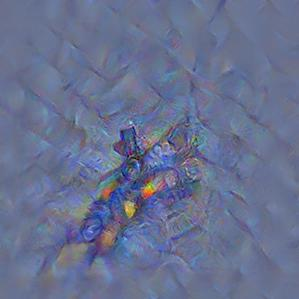

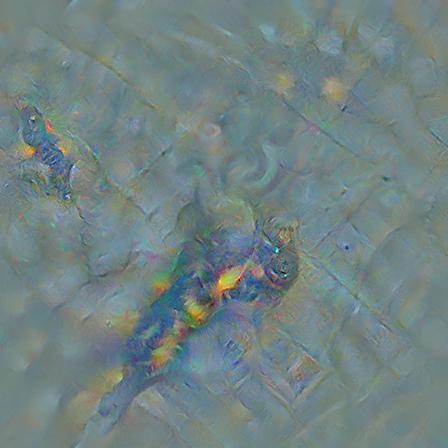

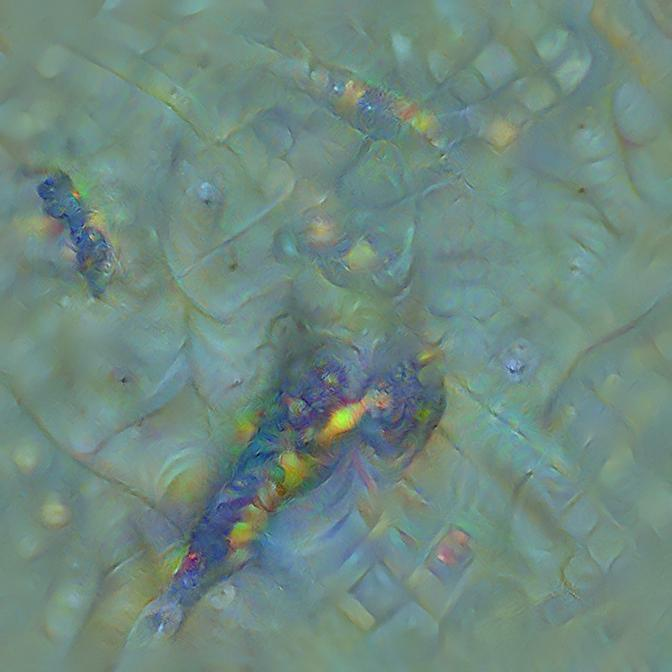

In [5]:
img = generate(25, octaves=3, scale=1.5)